**Modelo de red neuronal CNN**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo CNN
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [1]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
#Ignorar warnings
import warnings
warnings.filterwarnings("ignore")

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time

In [2]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [3]:
cd /content/gdrive/MyDrive/Tesis/Datos

/content/gdrive/MyDrive/Tesis/Datos


Se obtiene conjunto de datos

In [4]:
df=pd.read_csv('df.csv')
df=df.drop(['Year', 'Week', 'Day','Month','Size','Type'], axis=1)

In [5]:
df.set_index('Date', inplace=True)


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 380380 entries, 2010-02-05 to 2012-10-26
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         380380 non-null  int64  
 1   Dept          380380 non-null  int64  
 2   Weekly_Sales  380380 non-null  float64
 3   IsHoliday     380380 non-null  bool   
 4   Temperature   380380 non-null  float64
 5   Fuel_Price    380380 non-null  float64
 6   MarkDown1     380380 non-null  float64
 7   MarkDown2     380380 non-null  float64
 8   MarkDown3     380380 non-null  float64
 9   MarkDown4     380380 non-null  float64
 10  MarkDown5     380380 non-null  float64
 11  CPI           380380 non-null  float64
 12  Unemployment  380380 non-null  float64
dtypes: bool(1), float64(10), int64(2)
memory usage: 38.1+ MB


In [7]:
df.shape

(380380, 13)

In [8]:
#Setear semilla
np.random.seed(42)

#2. Obtener series de Tiempo

*Se obtiene lista de dataframe ordenados por Store y Dept*

In [9]:
series_time=[]
lista_Store=df.Store.unique()
lista_Store.sort()
lista_dept=df.Dept.unique()
lista_dept.sort()

for i in lista_Store:
  for j in lista_dept:
    #lista=[]
    test=df[(df.Store==i) & (df.Dept==j)]
    if(test.empty!=True):
        series_time.append(test)

In [10]:
len(series_time)

2660

#3.Normalizar base de datos

El **método de puntuación z** (a menudo llamado estandarización ) transforma los datos en una distribución con una media de 0 y una desviación estándar de 1 . Cada valor estandarizado se calcula restando la media de la característica correspondiente y luego dividiendo por la desviación estándar.

In [11]:
#Seleccion de caracteristicas
features =features = [feature for feature in df.columns if feature not in ('Store','Dept')]

#Se define escalado
std_scaler = StandardScaler()

series_time_scaled=[]

#Transformacion
for serie in series_time:
  for i in features:
    serie[i]=std_scaler.fit_transform(serie[i].values.reshape(-1,1))
  series_time_scaled.append(serie)

for i in features:
  df[i] = std_scaler.fit_transform(df[i].values.reshape(-1,1))

series_time_scaled[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,
2010-02-05,1,1,0.245542,-0.274204,-1.830686,-1.521079,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.130288,1.295958
2010-02-12,1,1,2.395781,3.646917,-2.098280,-1.577441,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.096657,1.295958
2010-02-19,1,1,1.943233,-0.274204,-1.998285,-1.657288,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.085823,1.295958
2010-02-26,1,1,-0.316684,-0.274204,-1.526473,-1.546911,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.078788,1.295958
2010-03-05,1,1,-0.069800,-0.274204,-1.535627,-1.396612,-0.524358,-0.193456,-0.092151,-0.336050,-0.579339,-1.071754,1.295958
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,1,1,-0.363093,-0.274204,0.547388,1.048107,0.141879,-0.191745,-0.091796,0.020611,0.956274,1.611008,-1.836849
2012-10-05,1,1,-0.062002,-0.274204,0.017127,0.933034,0.943562,-0.193456,-0.088232,0.573847,0.594358,1.657095,-2.712884
2012-10-12,1,1,0.025529,-0.274204,-0.374406,0.895459,-0.145256,-0.193456,-0.090407,-0.184537,1.338915,1.703183,-2.712884


In [12]:
len(series_time_scaled)

2660

In [13]:
import random
series_time_scaled=random.sample(series_time_scaled,20)

In [14]:
series_time_scaled[1]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,
2010-02-05,30,93,-0.273257,-0.274204,-1.908321,-1.521079,-0.451113,-0.204664,-0.281559,-0.243519,-0.546139,-1.130950,1.141694
2010-02-12,30,93,1.807581,3.646917,-1.990295,-1.577441,-0.451113,-0.204664,-0.281559,-0.243519,-0.546139,-1.097350,1.141694
2010-02-19,30,93,-0.406770,-0.274204,-1.863491,-1.657288,-0.451113,-0.204664,-0.281559,-0.243519,-0.546139,-1.086450,1.141694
2010-02-26,30,93,-0.467708,-0.274204,-1.507413,-1.546911,-0.451113,-0.204664,-0.281559,-0.243519,-0.546139,-1.079332,1.141694
2010-03-05,30,93,0.054256,-0.274204,-1.296072,-1.396612,-0.451113,-0.204664,-0.281559,-0.243519,-0.546139,-1.072215,1.141694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,30,93,-0.101601,-0.274204,0.738565,1.048107,0.201796,-0.204664,-0.281559,-0.243519,0.655231,1.610816,-1.726590
2012-10-05,30,93,0.877248,-0.274204,0.091733,0.933034,-0.451113,-0.204664,-0.092434,-0.243519,0.049143,1.656920,-2.370691
2012-10-12,30,93,1.210809,-0.274204,-0.468640,0.895459,-0.402225,-0.204664,0.044087,-0.243519,2.111602,1.703024,-2.370691


In [15]:
series_time_scaled[0]

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
Date,,,,,,,,,,,,,
2010-02-05,25,8,0.746293,-0.274204,-1.868054,-1.435200,-0.530232,-0.204150,-0.091757,-0.320073,-0.549282,-1.151085,2.682850
2010-02-12,25,8,-1.602477,3.646917,-1.955924,-1.460116,-0.530232,-0.204150,-0.091757,-0.320073,-0.549282,-1.117795,2.682850
2010-02-19,25,8,0.523099,-0.274204,-1.683887,-1.523540,-0.530232,-0.204150,-0.091757,-0.320073,-0.549282,-1.106658,2.682850
2010-02-26,25,8,-0.526469,-0.274204,-1.382960,-1.503154,-0.530232,-0.204150,-0.091757,-0.320073,-0.549282,-1.099213,2.682850
2010-03-05,25,8,0.405637,-0.274204,-1.365507,-1.451056,-0.530232,-0.204150,-0.091757,-0.320073,-0.549282,-1.091769,2.682850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-28,25,8,0.378218,-0.274204,0.143338,1.312392,0.383645,-0.201929,-0.089572,-0.286431,0.867724,1.609422,-0.300699
2012-10-05,25,8,1.079362,-0.274204,0.327505,1.285211,0.521940,-0.204150,-0.091087,0.437962,0.065369,1.654873,-0.257936
2012-10-12,25,8,1.311049,-0.274204,-0.505459,1.319188,0.235852,-0.204150,-0.089381,-0.042864,0.346850,1.700323,-0.257936


#4.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [16]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [17]:
series_predic=[]
series_target=[]
for serie in series_time_scaled:
  serie_split = []
  for columna in serie:
    col_df = time_delay_embedding(
        serie[columna],     #Serie de tiempo
        n_lags=1,           #Numero de retrasos
        horizon=1           # Horizonte de prediccion
          )
    serie_split.append(col_df)

  serie_df = pd.concat(serie_split, axis=1).dropna()
  predictor_variables = serie_df.columns.str.contains('\(t\-')
  target_variables = serie_df.columns.str.contains('Weekly_Sales\(t\+')

  predictor_variables = serie_df.iloc[:, predictor_variables]
  target_variables = serie_df.iloc[:, target_variables]
  series_predic.append(predictor_variables)
  series_target.append(target_variables)

In [18]:
#Ejemplo de variables de prediccion de una serie
series_predic[0].head()

,Store(t-0),Dept(t-0),Weekly_Sales(t-0),IsHoliday(t-0),Temperature(t-0),Fuel_Price(t-0),MarkDown1(t-0),MarkDown2(t-0),MarkDown3(t-0),MarkDown4(t-0),MarkDown5(t-0),CPI(t-0),Unemployment(t-0)
Date,,,,,,,,,,,,,
2010-02-12,25.0,8.0,0.746293,-0.274204,-1.868054,-1.435200,-0.530232,-0.20415,-0.091757,-0.320073,-0.549282,-1.151085,2.68285
2010-02-19,25.0,8.0,-1.602477,3.646917,-1.955924,-1.460116,-0.530232,-0.20415,-0.091757,-0.320073,-0.549282,-1.117795,2.68285
2010-02-26,25.0,8.0,0.523099,-0.274204,-1.683887,-1.523540,-0.530232,-0.20415,-0.091757,-0.320073,-0.549282,-1.106658,2.68285
2010-03-05,25.0,8.0,-0.526469,-0.274204,-1.382960,-1.503154,-0.530232,-0.20415,-0.091757,-0.320073,-0.549282,-1.099213,2.68285
2010-03-12,25.0,8.0,0.405637,-0.274204,-1.365507,-1.451056,-0.530232,-0.20415,-0.091757,-0.320073,-0.549282,-1.091769,2.68285


In [19]:
#Ejemplo de variables objetivo de una serie
series_target[0].head()

,Weekly_Sales(t+1)
Date,
2010-02-12,-1.602477
2010-02-19,0.523099
2010-02-26,-0.526469
2010-03-05,0.405637
2010-03-12,-0.813432


In [20]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %20 de la data para test
X_train=pd.DataFrame()
X_test=pd.DataFrame()
Y_train=pd.DataFrame()
Y_test=pd.DataFrame()

for serie,target in zip(series_predic,series_target):
  X_train_i, X_test_i, Y_train_i, Y_test_i = train_test_split(serie, target, test_size=0.2, shuffle=False)
  X_train=pd.concat([X_train, X_train_i])
  X_test=pd.concat([X_test, X_test_i])
  Y_train=pd.concat([Y_train, Y_train_i])
  Y_test=pd.concat([Y_test, Y_test_i])

shape_x_test=X_test.shape
shape_y_test=Y_test.shape
shape=len(X_train.columns)

print("Separacion de datos terminada!")

Separacion de datos terminada!


#CNN

In [21]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [22]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, feature,timesteps]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0],Y_train_s.shape[1],1))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],1))

In [23]:
# Función para crear el modelo, requerida para KerasRegressor
def create_model(neurons, dropout,layers,learning_rate,filters,kernel_size):

    #Creacion del modelo CNN
    model = Sequential()
    for i in range(layers):
      if i == 0:
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, input_shape=(X_train.shape[1],X_train.shape[2])))
      else:
        model.add(Conv1D(filters=filters, kernel_size=kernel_size))
      model.add(MaxPooling1D(2))

    model.add(Flatten())
    model.add(Dense(neurons))
    model.add(Dropout(dropout))

    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [24]:
def objective(params):

    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']
    filters = params['filters']
    kernel_size = params['kernel_size']


    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      # Crear el modelo de CNN
      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate),int(filters),int(kernel_size))

      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()


      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)


      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [25]:
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size': hp.quniform('batch_size', 10, 100, 10),
    'optimizer': 'adam',
    'neurons': hp.quniform('neurons', 100, 800, 100),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 2, 1),
    'learning_rate':hp.uniform('learning_rate', 0.00001, 0.00005),
    'filters': hp.quniform('filters', 32, 256, 32),
    'kernel_size':hp.choice('kernel_size', [2,4]),
}

In [26]:
#Optimización bayesiana
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

print("Los mejores hiperparámetros son: ", best)


100%|██████████| 50/50 [1:43:26<00:00, 124.12s/trial, best loss: 91.19288639783859]
Los mejores hiperparámetros son:  {'batch_size': 90.0, 'dropout': 0.44570525151643264, 'filters': 160.0, 'kernel_size': 0, 'layers': 1.0, 'learning_rate': 4.500899952960927e-05, 'neurons': 100.0}


In [27]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores']

In [28]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [29]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 90.0,
 'dropout': 0.44570525151643264,
 'epochs': 800,
 'filters': 160.0,
 'kernel_size': 2,
 'layers': 1.0,
 'learning_rate': 4.500899952960927e-05,
 'neurons': 100.0,
 'optimizer': 'adam'}

# 6.Evaluacion del modelo

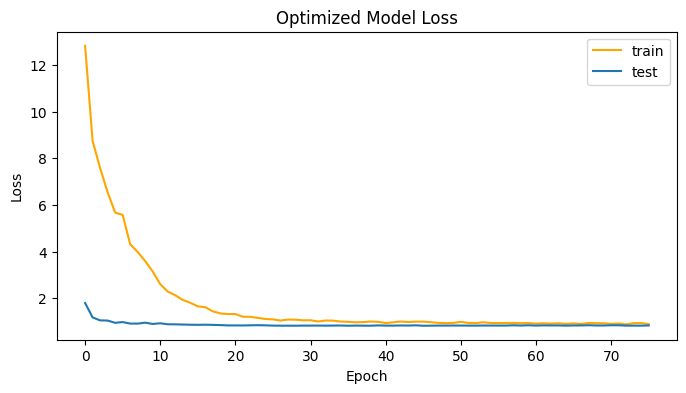

In [30]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [31]:
#Se realiza prediccion
results = best_model.predict(X_test)

results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

19/19 [==============================] - 0s 2ms/step


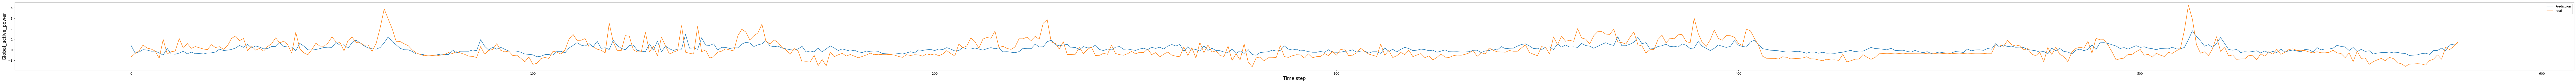

In [32]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(150,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [33]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.5113591551780701
RMSE: 0.7150937914848328
MAE: 0.5532287359237671
MAPE: 218.72067260742188


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [34]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "CNN_Wallmart"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])+"_"+str(result['params']['kernel_size'])+"_"+str(result['params']['filters'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [35]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [36]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
94,CNN_Wallmart_19_5_800_100.0_2.0_100.0_0.51_ada...,19,5,23.888380,0.412506,0.642267,0.460968,216.787018
213,CNN_Wallmart_43_4_800_10.0_2.0_200.0_0.46_adam...,43,4,108.787956,0.412562,0.642310,0.474048,237.853683
193,CNN_Wallmart_39_4_800_40.0_2.0_400.0_0.43_adam...,39,4,25.038480,0.425129,0.652019,0.475345,203.360809
68,CNN_Wallmart_14_4_800_70.0_2.0_700.0_0.66_adam...,14,4,27.102685,0.429269,0.655186,0.477540,241.695984
212,CNN_Wallmart_43_3_800_10.0_2.0_200.0_0.46_adam...,43,3,108.869204,0.429327,0.655230,0.470942,190.905502


In [37]:
# Exportar el DataFrame como CSV
results_csv.to_csv('results_CNN_Wallmart.csv')

Se guarda cada modelo keras en un objeto Json

In [38]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos/result_CNN'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [39]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "CNN_Wallmart" +"_"+str(trial)+"_"+str(k) +  "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])+"_"+str(result['params']['kernel_size'])+"_"+str(result['params']['filters'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1